# Summer 2024 Data Science Project
## By: William Lin, Joey Kim, Alex Zheng, and Jeffrey Liu

## Introduction
The goal of this project is to analyze the MotionSense dataset, which contains motion sensor data collected from smartphones while participants performed various physical activities. The primary questions we aim to answer are:

How can motion sensor data be used to classify different physical activities?
What are the patterns and characteristics of the data that can help in classification?
Could we "Fingerprint" users from their movement patterns?
Answering these questions is important because it can enhance activity recognition systems, which have applications in health monitoring, sports analytics, and other domains where understanding physical activity is crucial.

## Data Curation
**Data Source**: The MotionSense dataset is available at [[MotionSense Dataset : Smartphone Sensor Data - HAR]](https://www.kaggle.com/datasets/malekzadeh/motionsense-dataset/data). <br>
**Description**: This dataset includes accelerometer and gyroscope data from smartphones, collected while participants performed various activities such as walking, jogging, sitting, standing, and more. The accelerometer produced user acceleration and gravity readings while gyroscope produced axis and rotation rate readings.<br>
**Transformation**:
<ol>
    <li>Imported the data into a pandas DataFrame: All CSV files containing the motion sensor data were read into pandas DataFrames for analysis.</li>
    <li>Data Cleaning and Parsing: The data was cleaned by renaming files for consistency and extracting relevant information from file names and folder names to add as columns in the DataFrame.</li>
    <li>Combining Data: All individual DataFrames were combined into a single DataFrame, and columns were renamed for clarity and consistency.</li>
</ol>

**Imports**

In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sci
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from pathlib import Path

**Read subject information**

In [2]:
subjects = pd.read_csv("./data_subjects_info.csv")
subjects

,code,weight,height,age,gender
0,1,102,188,46,1
1,2,72,180,28,1
2,3,48,161,28,0
3,4,90,176,31,1
4,5,48,164,23,0
5,6,76,180,28,1
6,7,62,175,30,0
7,8,52,161,24,0
8,9,93,190,32,1
9,10,72,164,31,0


**Rename Files** <br>
This is for parsing and ordering purposes. <br>
/*Note: We have already ran this and no longer needs to be ran*/

In [3]:
'''
# Define a function to rename a file
def rm(old_file_path, new_file_name):
    # Get the directory path of the old file
    dir_path = os.path.dirname(old_file_path)
    # Create the new file path
    new_file_path = os.path.join(dir_path, new_file_name)
    # Rename the old file to the new file name
    os.rename(old_file_path, new_file_path)

# List all folders in the specified directory
folders = os.listdir(r'A_DeviceMotion_data/')

# Iterate over each folder
for folder in folders:
    # Split the folder name to get its components
    folder_name = folder.split('_')

    # If the second part of the folder name is less than or equal to 9, rename the folder
    if int(folder_name[1]) <= 9:
        old_folder_path = './A_DeviceMotion_data/' + folder  # Old folder path
        new_folder_name = folder_name[0] + "_0" + folder_name[1]  # New folder name with leading zero
        folder = new_folder_name  # Update the folder variable with the new name
        
        # Rename the old folder to the new folder name
        rm(old_folder_path, new_folder_name)

    # List all files in the current (possibly renamed) folder
    files = os.listdir(r'./A_DeviceMotion_data/' + folder)

    # Iterate over each file in the folder
    for file in files:
        # Split the file name to get its components
        file_name = re.split('_|\\.', file)
        
        # If the second part of the file name is less than or equal to 9, rename the file
        if int(file_name[1]) <= 9:
            old_file_path = './A_DeviceMotion_data/' + folder + '/' + file  # Old file path
            new_file_name = 'sub_0' + file_name[1] + '.csv'  # New file name with leading zero

            # Rename the old file to the new file name
            rm(old_file_path, new_file_name)
'''

'\n# Define a function to rename a file\ndef rm(old_file_path, new_file_name):\n    # Get the directory path of the old file\n    dir_path = os.path.dirname(old_file_path)\n    # Create the new file path\n    new_file_path = os.path.join(dir_path, new_file_name)\n    # Rename the old file to the new file name\n    os.rename(old_file_path, new_file_path)\n\n# List all folders in the specified directory\nfolders = os.listdir(r\'A_DeviceMotion_data/\')\n\n# Iterate over each folder\nfor folder in folders:\n    # Split the folder name to get its components\n    folder_name = folder.split(\'_\')\n\n    # If the second part of the folder name is less than or equal to 9, rename the folder\n    if int(folder_name[1]) <= 9:\n        old_folder_path = \'./A_DeviceMotion_data/\' + folder  # Old folder path\n        new_folder_name = folder_name[0] + "_0" + folder_name[1]  # New folder name with leading zero\n        folder = new_folder_name  # Update the folder variable with the new name\n       

Combines all CSVs with labeled columns for easier analysis.

In [4]:
# Initialize an empty list to store the dataframes
dfs = list()

# List all folders in the specified directory
folders = os.listdir(r'A_DeviceMotion_data/')
for folder in folders:
    # Create the full path to the current folder
    path = r'A_DeviceMotion_data/' + folder
    
    # Get a list of all CSV files in the current folder
    files = Path(path).glob('*.csv')
    
    # Iterate over each file in the current folder
    for file in files:
        # Read the CSV file into a dataframe
        data = pd.read_csv(file)
        
        # Extract the subject code from the file name and add it as a new column
        data['subject_code'] = int(file.stem.split('_')[1])
        
        # Extract the motion type from the folder name and add it as a new column
        data['motion_type'] = folder.split('_')[0]
        
        # Determine the trial type based on the folder name and add it as a new column
        data['trial_type'] = "long" if int(folder.split('_')[1]) <= 9 else "short"
        
        # Add the file path as a new column
        data['file_path'] = folder
        
        # Append the dataframe to the list of dataframes
        dfs.append(data)

# Concatenate all dataframes in the list into a single dataframe
df = pd.concat(dfs, ignore_index=True)

# Rename the 'Unnamed: 0' column to 'reading_number'
df.rename(columns={'Unnamed: 0': 'reading_number'}, inplace=True)

# Display the dataframe (optional)
df.head()

,reading_number,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject_code,motion_type,trial_type,file_path
0,0,-2.116381,-1.077507,-2.261502,-0.404768,0.880780,0.245713,-1.264215,-1.027909,-0.947909,0.282683,-0.254346,-0.407670,12,dws,short,dws_11
1,1,-2.148154,-1.049759,-2.284278,-0.417081,0.867303,0.271686,-1.162024,-0.269118,-0.848823,0.256712,0.079154,-0.560291,12,dws,short,dws_11
2,2,-2.153824,-1.026749,-2.297008,-0.432082,0.855621,0.284961,-0.665042,0.520170,-0.726722,0.253600,0.346680,-0.463275,12,dws,short,dws_11
3,3,-2.142509,-1.012749,-2.290595,-0.445311,0.848291,0.286507,-0.079809,0.055322,-0.604534,0.411818,0.459372,-0.510293,12,dws,short,dws_11
4,4,-2.130486,-1.007262,-2.274149,-0.452661,0.845372,0.283600,0.456097,-0.186877,-0.441315,0.311594,0.477305,-0.925049,12,dws,short,dws_11


### Basic Data Exploration

In [5]:
df.motion_type.unique()

array(['dws', 'ups', 'std', 'wlk', 'jog', 'sit'], dtype=object)

In [6]:
df.dtypes

reading_number          int64
attitude.roll         float64
attitude.pitch        float64
attitude.yaw          float64
gravity.x             float64
gravity.y             float64
gravity.z             float64
rotationRate.x        float64
rotationRate.y        float64
rotationRate.z        float64
userAcceleration.x    float64
userAcceleration.y    float64
userAcceleration.z    float64
subject_code            int64
motion_type            object
trial_type             object
file_path              object
dtype: object

In [7]:
print('Rows: '+ str(len(df)) +'\nCols: '+ str(len(df.columns)))
df.columns

Rows: 1412865
Cols: 17


Index(['reading_number', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'subject_code',
       'motion_type', 'trial_type', 'file_path'],
      dtype='object')

In [8]:
df.count()

reading_number        1412865
attitude.roll         1412865
attitude.pitch        1412865
attitude.yaw          1412865
gravity.x             1412865
gravity.y             1412865
gravity.z             1412865
rotationRate.x        1412865
rotationRate.y        1412865
rotationRate.z        1412865
userAcceleration.x    1412865
userAcceleration.y    1412865
userAcceleration.z    1412865
subject_code          1412865
motion_type           1412865
trial_type            1412865
file_path             1412865
dtype: int64

In [9]:
df.isna().sum()

reading_number        0
attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
subject_code          0
motion_type           0
trial_type            0
file_path             0
dtype: int64

Duplicates

In [10]:
# Drop columns that are supposed to have duplicates
df_reduced = df.drop(columns=['reading_number', 'subject_code', 'motion_type', 'trial_type', 'file_path'])

# Check for duplicated rows
duplicated_rows = df_reduced.duplicated()

# Count the number of True and False values
true_count = duplicated_rows.sum()
false_count = len(duplicated_rows) - true_count

# Display the counts
print(f"Number of True (duplicates): {true_count}")
print(f"Number of False (unique): {false_count}")

Number of True (duplicates): 10292
Number of False (unique): 1402573


We wouldn't necessarily want to drop duplicates since every piece of sensor reading matters.

**Frequencies of Motion Types**

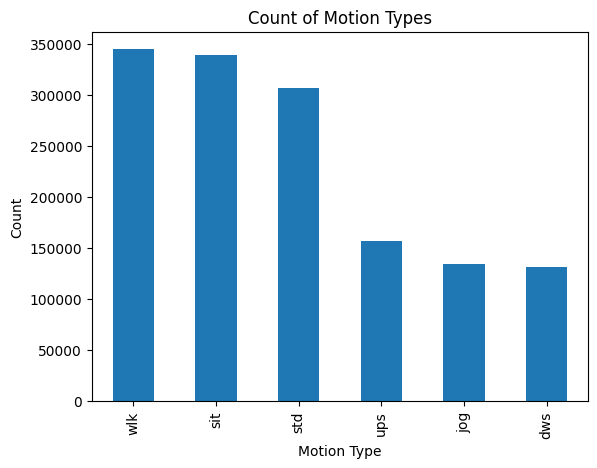

In [11]:
df['motion_type'].value_counts().plot(kind='bar')
plt.xlabel('Motion Type')
plt.ylabel('Count')
plt.title('Count of Motion Types')
plt.show()

It seems that our data has way more readings from walking trials compared to other trials. Why is the number of readings for sitting trials comparable to the number of walking trials but jogging and downstair traisl are so low.

## Summary Statistics and Subject Analysis
In this exploration we will reveal some basic summary statistics about each motion type. Then we will take a closer look at subjects. We will be making some modifications to the dataframe so we will be creating a copy as we still want to preserve the original dataframe for later explorations.

In [12]:
df_1 = df

In [13]:
df_1.groupby('motion_type').describe()

reading_number                                                 \
                     count         mean          std  min     25%     50%   
motion_type                                                                 
dws               131856.0  1066.908112   729.834649  0.0   458.0   945.0   
jog               134231.0  1877.280069  1365.103808  0.0   699.0  1574.0   
sit               338778.0  4248.913870  2966.014729  0.0  1764.0  3675.5   
std               306427.0  4093.049640  3069.660731  0.0  1595.0  3410.0   
ups               157285.0  1277.358464   876.498400  0.0   548.0  1121.0   
wlk               344288.0  2724.287901  1823.930946  0.0  1195.0  2444.0   

                             attitude.roll            ... userAcceleration.z  \
                75%      max         count      mean  ...                75%   
motion_type                                           ...                      
dws          1596.0   3435.0      131856.0 -0.033188  ...           0.196645   
jog          2953.0   5534.0      134231.0 -0.243816  ...           0.447604   
sit          6471.0  12756.0      338778.0 -0.401699  ...           0.003907   
std          6175.0  16423.0      306427.0 -0.263079  ...           0.036826   
ups          1930.0   4085.0      157285.0  0.137404  ...           0.166341   
wlk          4077.0   8401.0      344288.0 -0.048016  ...           0.388944   

                      subject_code                                             \
                  max        count       mean       std  min  25%   50%   75%   
motion_type                                                                     
dws          4.866772     131856.0  12.512104  6.909391  1.0  6.0  12.0  18.0   
jog          8.125357     134231.0  12.410255  7.025148  1.0  6.0  12.0  19.0   
sit          0.876057     338778.0  12.123934  6.865786  1.0  6.0  12.0  18.0   
std          1.269990     306427.0  12.732233  6.902665  1.0  7.0  13.0  19.0   
ups          2.482116     157285.0  12.668722  6.954252  1.0  7.0  13.0  19.0   
wlk          4.352533     344288.0  12.500688  6.941128  1.0  6.0  13.0  19.0   

                   
              max  
motion_type        
dws          24.0  
jog          24.0  
sit          24.0  
std          24.0  
ups          24.0  
wlk          24.0  

[6 rows x 112 columns]

Let's plot the average user acceleration. Since we aren't really worying about the specific direction of the acceleration, I will just plot the mean norm acceleration.

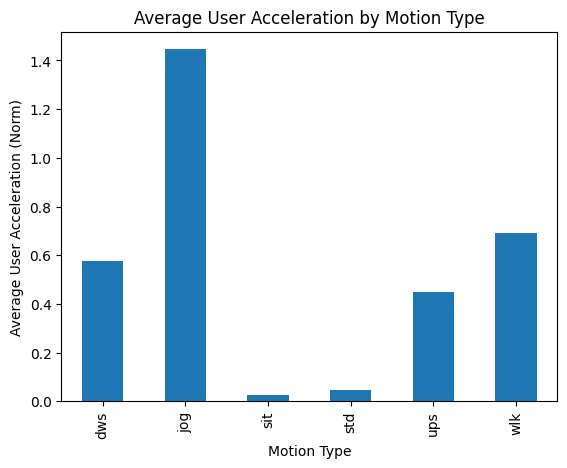

In [14]:
df_1['user_acceleration_norm'] = np.sqrt(
    df_1['userAcceleration.x']**2 + df_1['userAcceleration.y']**2 + df_1['userAcceleration.z']**2
)

df_1.groupby('motion_type')['user_acceleration_norm'].mean().plot(kind="bar")
plt.xlabel('Motion Type')
plt.ylabel('Average User Acceleration (Norm)')
plt.title('Average User Acceleration by Motion Type')
plt.show()

Notice that jogging exhibits the highest average user acceleration since it is the most intense activity among the motion types. Closely followed behind is walking and stair movement. This make sense as sitting and standing require little to no movement as all. Similarly, we can plot the average attitude, gravity, rotation rate.

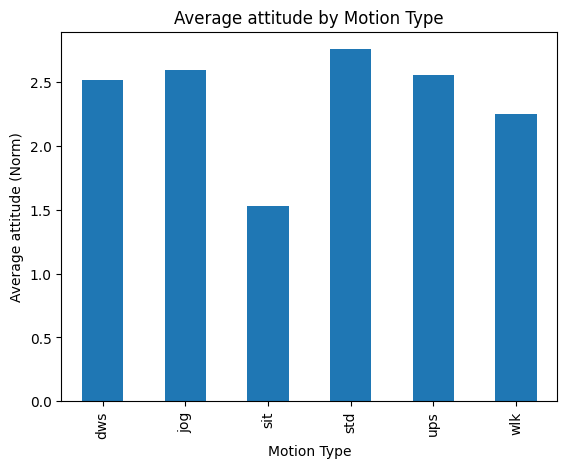

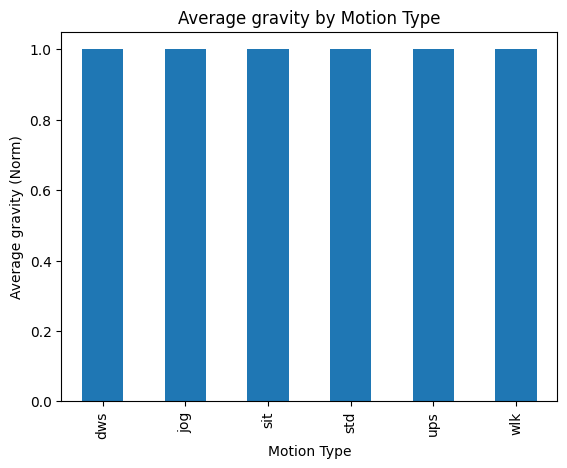

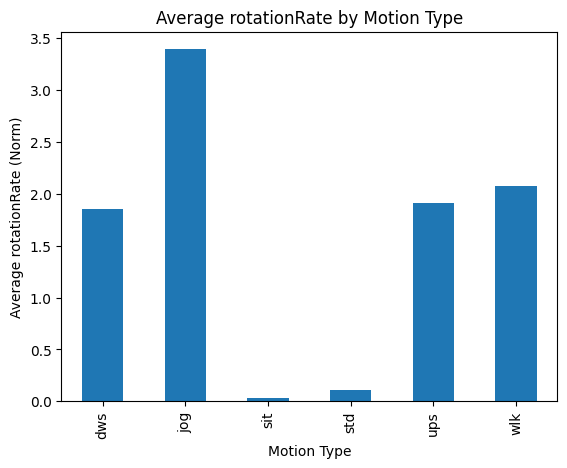

In [15]:
df_1['attitude_norm'] = np.sqrt(
    df_1['attitude.roll']**2 + df_1['attitude.pitch']**2 + df_1['attitude.yaw']**2
)
df_1['gravity_norm'] = np.sqrt(
    df_1['gravity.x']**2 + df_1['gravity.y']**2 + df_1['gravity.z']**2
)
df_1['rotationRate_norm'] = np.sqrt(
    df_1['rotationRate.x']**2 + df_1['rotationRate.y']**2 + df_1['rotationRate.z']**2
)

for move in ['attitude', 'gravity', 'rotationRate']:
    df_1.groupby('motion_type')[move + '_norm'].mean().plot(kind="bar")
    plt.xlabel('Motion Type')
    plt.ylabel('Average ' + move +' (Norm)')
    plt.title('Average '+ move +' by Motion Type')
    plt.show()

In [16]:
df_1.drop('user_acceleration_norm', axis=1, inplace=True)
df_1.drop('attitude_norm', axis=1, inplace=True)
df_1.drop('gravity_norm', axis=1, inplace=True)
df_1.drop('rotationRate_norm', axis=1, inplace=True)

**Closer look at our subjects**

Which user has the highest average acceleration when doing a long jog?

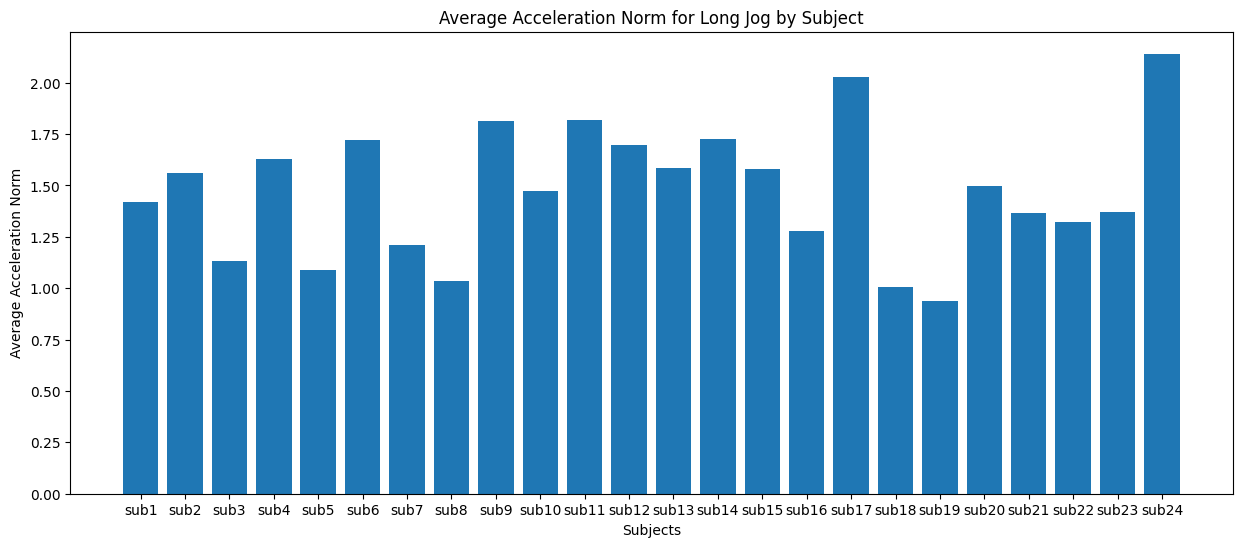

In [17]:
averages = []
for code in range(1, 25):
    # Filter the DataFrame using .loc to safely create a new DataFrame
    filtered_data = df_1.loc[
        (df_1['motion_type'] == 'jog') & (df_1['trial_type'] == 'long') & (df_1['subject_code'] == code)
    ].copy()  # Use .copy() to avoid SettingWithCopyWarning when you modify filtered_data below
    
    # Calculate the norm and store it directly in the filtered DataFrame
    filtered_data['user_acceleration_norm'] = np.sqrt(
        filtered_data['userAcceleration.x']**2 + 
        filtered_data['userAcceleration.y']**2 + 
        filtered_data['userAcceleration.z']**2
    )
    
    # Append the mean of the acceleration norm to the averages list
    averages.append(filtered_data['user_acceleration_norm'].mean())

subs = [f'sub{num}' for num in range(1, 25)]
plt.figure(figsize=(15, 6))
plt.bar(subs, averages)
plt.xlabel('Subjects')
plt.ylabel('Average Acceleration Norm')
plt.title('Average Acceleration Norm for Long Jog by Subject')
plt.show()


In [18]:
subjects[subjects['code'] == 24]

,code,weight,height,age,gender
23,24,74,173,18,0


Notice that subject 24 had the highest average acceleration during the long job. This makes sense as they are fairly young.

## Correlation Analysis of Motion Sensor Metrics

**Organizing Data**

In [19]:
# deep copy for now so any potential changes dont affect other pushes
df3 = df.copy(deep=True)
metrics = ['attitude.roll', 'attitude.pitch', 'attitude.yaw',
           'rotationRate.x', 'rotationRate.y', 'rotationRate.z',
           'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

# getting the rotation data for each motion_type
grouped = df3.groupby(by=['motion_type', 'subject_code'])

metric_series = {}
obs_counts = {}
motion_avgs = {}

# the idea is that the mean value of each metric for each (motion_type, subject) pair 
# is more or less a accurate summary of of that pair's associated observations

# since they are from the same individual, it makes sense to weigh each observation equally
for m in metrics:
    metric_series[m] = grouped[m].mean()
    obs_counts[m] = grouped[m].count()

# df where indices are unique (motion_type, subject_code)
motion_subject_df = pd.DataFrame(data=metric_series, columns=metrics)
motion_subject_count_df = pd.DataFrame(data=obs_counts, columns=metrics)

# made 'motion_type' a dictionary key for easy search
motion_types = {'dws','jog','sit','std','ups', 'wlk'}
for t in motion_types:
    motion_avgs[t] = motion_subject_df.loc[t]

motion_subject_count_df.head(5)

attitude.roll  attitude.pitch  attitude.yaw  \
motion_type subject_code                                                
dws         1                      5105            5105          5105   
            2                      5878            5878          5878   
            3                      6324            6324          6324   
            4                      5086            5086          5086   
            5                      5049            5049          5049   

                          rotationRate.x  rotationRate.y  rotationRate.z  \
motion_type subject_code                                                   
dws         1                       5105            5105            5105   
            2                       5878            5878            5878   
            3                       6324            6324            6324   
            4                       5086            5086            5086   
            5                       5049            5049            5049   

                          userAcceleration.x  userAcceleration.y  \
motion_type subject_code                                           
dws         1                           5105                5105   
            2                           5878                5878   
            3                           6324                6324   
            4                           5086                5086   
            5                           5049                5049   

                          userAcceleration.z  
motion_type subject_code                      
dws         1                           5105  
            2                           5878  
            3                           6324  
            4                           5086  
            5                           5049

**Visualization** <br>
Here are some basic scatterplots that show the correlation between each metric.

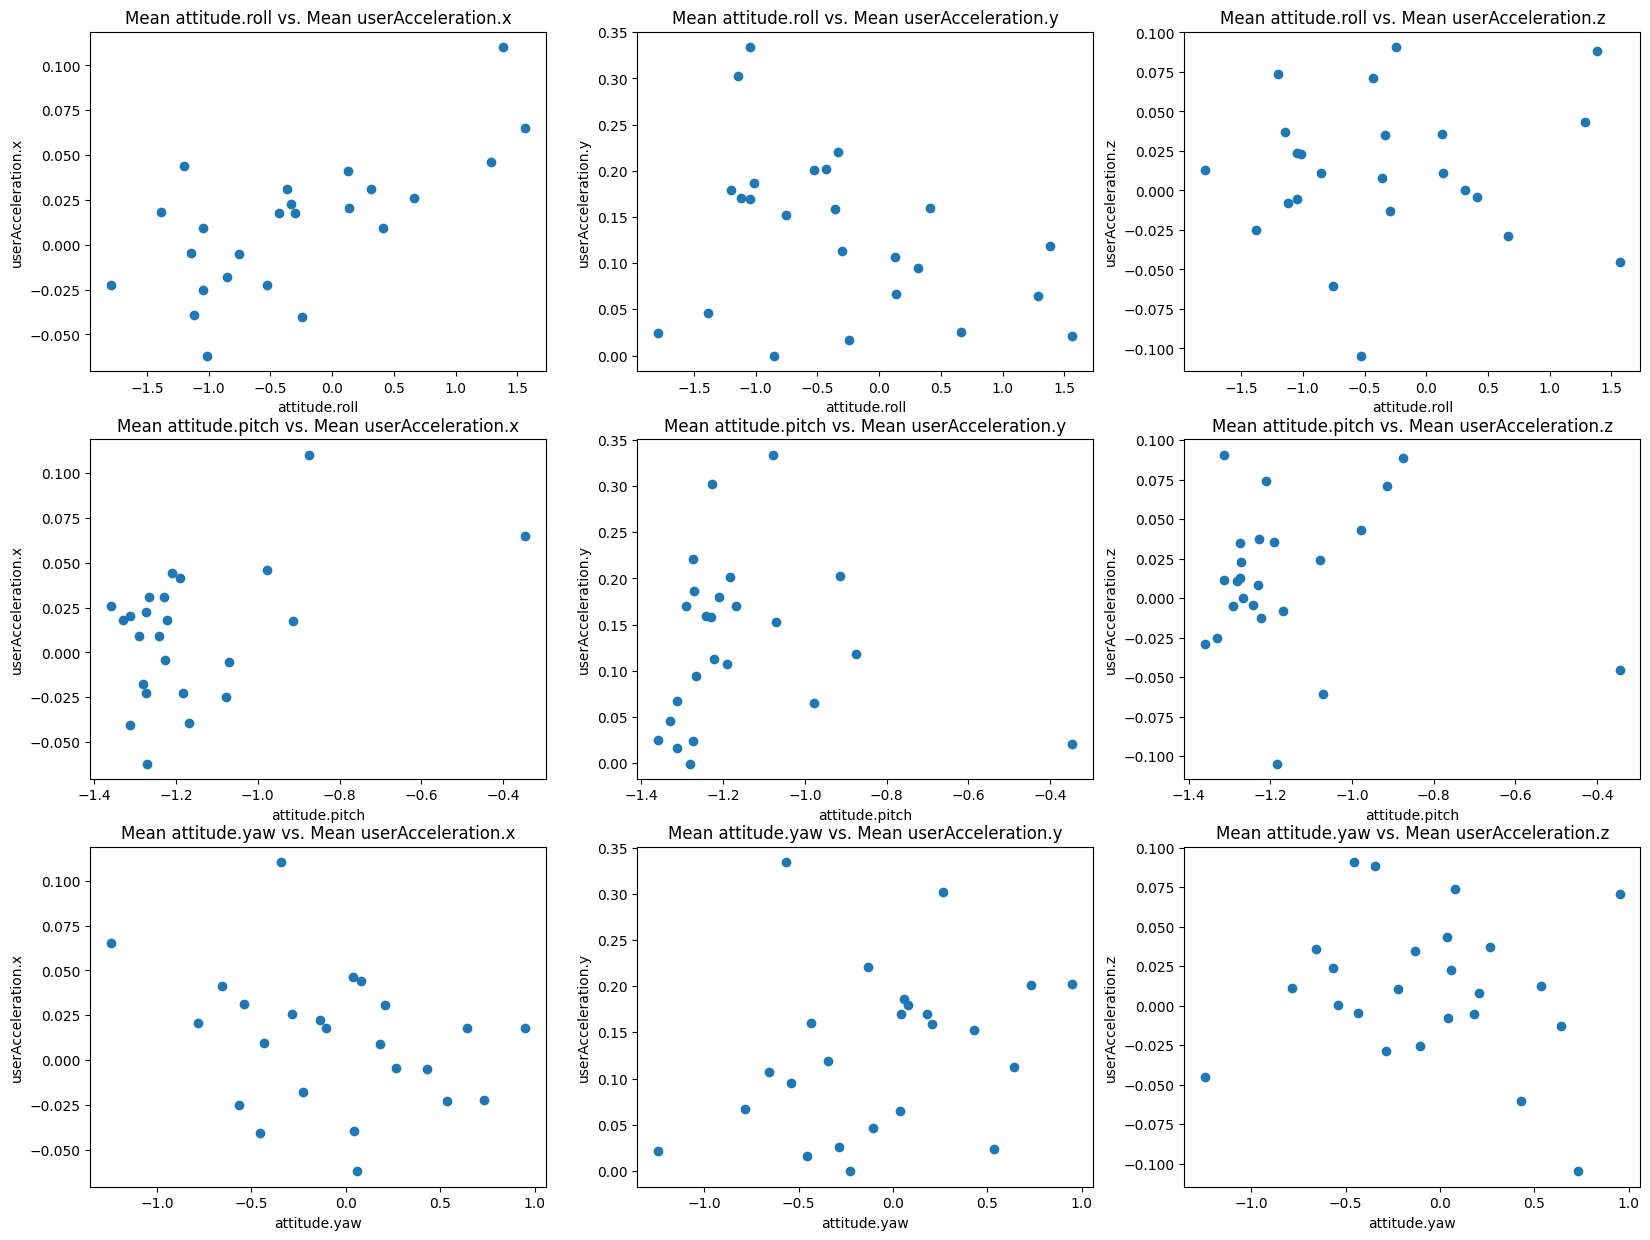

In [20]:
attitudes = ['attitude.roll', 'attitude.pitch', 'attitude.yaw']
accelerations = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

jog_df = motion_avgs['jog']

figure, axis = plt.subplots(3, 3, figsize=(20, 15))

x=0
for attitude in attitudes:
    y = 0
    for acceleration in accelerations:
        axis[x,y].scatter(jog_df[attitude],jog_df[acceleration])
        axis[x,y].set_title('Mean ' + attitude + ' vs. Mean '+ acceleration)
        axis[x,y].set_xlabel(attitude)
        axis[x,y].set_ylabel(acceleration)
        y+=1
    x+=1
plt.show()

Attitude.pitch seems to be positively correlated to userAcceleration.x with a medium to strong correlation. attitude.yaw seems to be correlated positively with userAcceleration.y and negatively with userAccleration.x with a weak correlation for both. attitude.roll seems to have a medium to strong positive correlationi with userAcceleration.x

**Pearson Correlation Coefficient and Linear Regression T-test** <br>
We will test the correlations seen from above using a hypothesis test. <br>
Note that we will be performing a t-test on the slopes.

Alpha: 0.05

Null Hypothesis: There is no correlation among the attitudes and accelerations during jogging. (Slope = 0)

Alternative Hypothesis: There is some correlation among the attitudes and accelerations during jogging. (Slope != 0)

In [21]:
for attitude in attitudes:
    for acceleration in accelerations:
        r, p_value = sci.pearsonr(jog_df[attitude],jog_df[acceleration])
        print('Correlation of '+attitude+' and '+acceleration+':', r)
        print('p-val =', p_value)
        print("____________________________________________________________________________")

Correlation of attitude.roll and userAcceleration.x: 0.687537559296495
p-val = 0.0002054366023150915
____________________________________________________________________________
Correlation of attitude.roll and userAcceleration.y: -0.34281931189241355
p-val = 0.10101708717741253
____________________________________________________________________________
Correlation of attitude.roll and userAcceleration.z: 0.0564561959075717
p-val = 0.7933046742999714
____________________________________________________________________________
Correlation of attitude.pitch and userAcceleration.x: 0.4717061425709037
p-val = 0.019961936222275753
____________________________________________________________________________
Correlation of attitude.pitch and userAcceleration.y: -0.031758210350871424
p-val = 0.8828842239167116
____________________________________________________________________________
Correlation of attitude.pitch and userAcceleration.z: -0.032046407623956656
p-val = 0.8818286577647568
_____

So it seems that the only statistically significant correlation we can have between the attitude and user acceleration means is between the roll of attitude and the user acceleration in the x direction. More specifically that means there is a statistically significant correlation between "rocking side to side" (the axis for roll of attitude is normal to the coronal plane) and moving forward. Intuitively, one could imagine that the change in speed requires a conservation of the motion or a change in the stride pattern leading to this roll.

We will be doing a similar analysis for gravity and rotation rate.

In [22]:
#Again
data_df = df.copy(deep=True)
metrics = ['gravity.x', 'gravity.y', 'gravity.z',
           'rotationRate.x', 'rotationRate.y', 'rotationRate.z',
           'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

grouped = data_df.groupby(by=['motion_type', 'subject_code'])

metric_series = {}
obs_counts = {}
motion_avgs = {}

for m in metrics:
    metric_series[m] = grouped[m].mean()
    obs_counts[m] = grouped[m].count()

motion_subject_df = pd.DataFrame(data=metric_series, columns=metrics)
motion_subject_count_df = pd.DataFrame(data=obs_counts, columns=metrics)

for t in motion_types:
    motion_avgs[t] = motion_subject_df.loc[t]

motion_subject_count_df.head(5)

gravity.x  gravity.y  gravity.z  rotationRate.x  \
motion_type subject_code                                                    
dws         1                  5105       5105       5105            5105   
            2                  5878       5878       5878            5878   
            3                  6324       6324       6324            6324   
            4                  5086       5086       5086            5086   
            5                  5049       5049       5049            5049   

                          rotationRate.y  rotationRate.z  userAcceleration.x  \
motion_type subject_code                                                       
dws         1                       5105            5105                5105   
            2                       5878            5878                5878   
            3                       6324            6324                6324   
            4                       5086            5086                5086   
            5                       5049            5049                5049   

                          userAcceleration.y  userAcceleration.z  
motion_type subject_code                                          
dws         1                           5105                5105  
            2                           5878                5878  
            3                           6324                6324  
            4                           5086                5086  
            5                           5049                5049

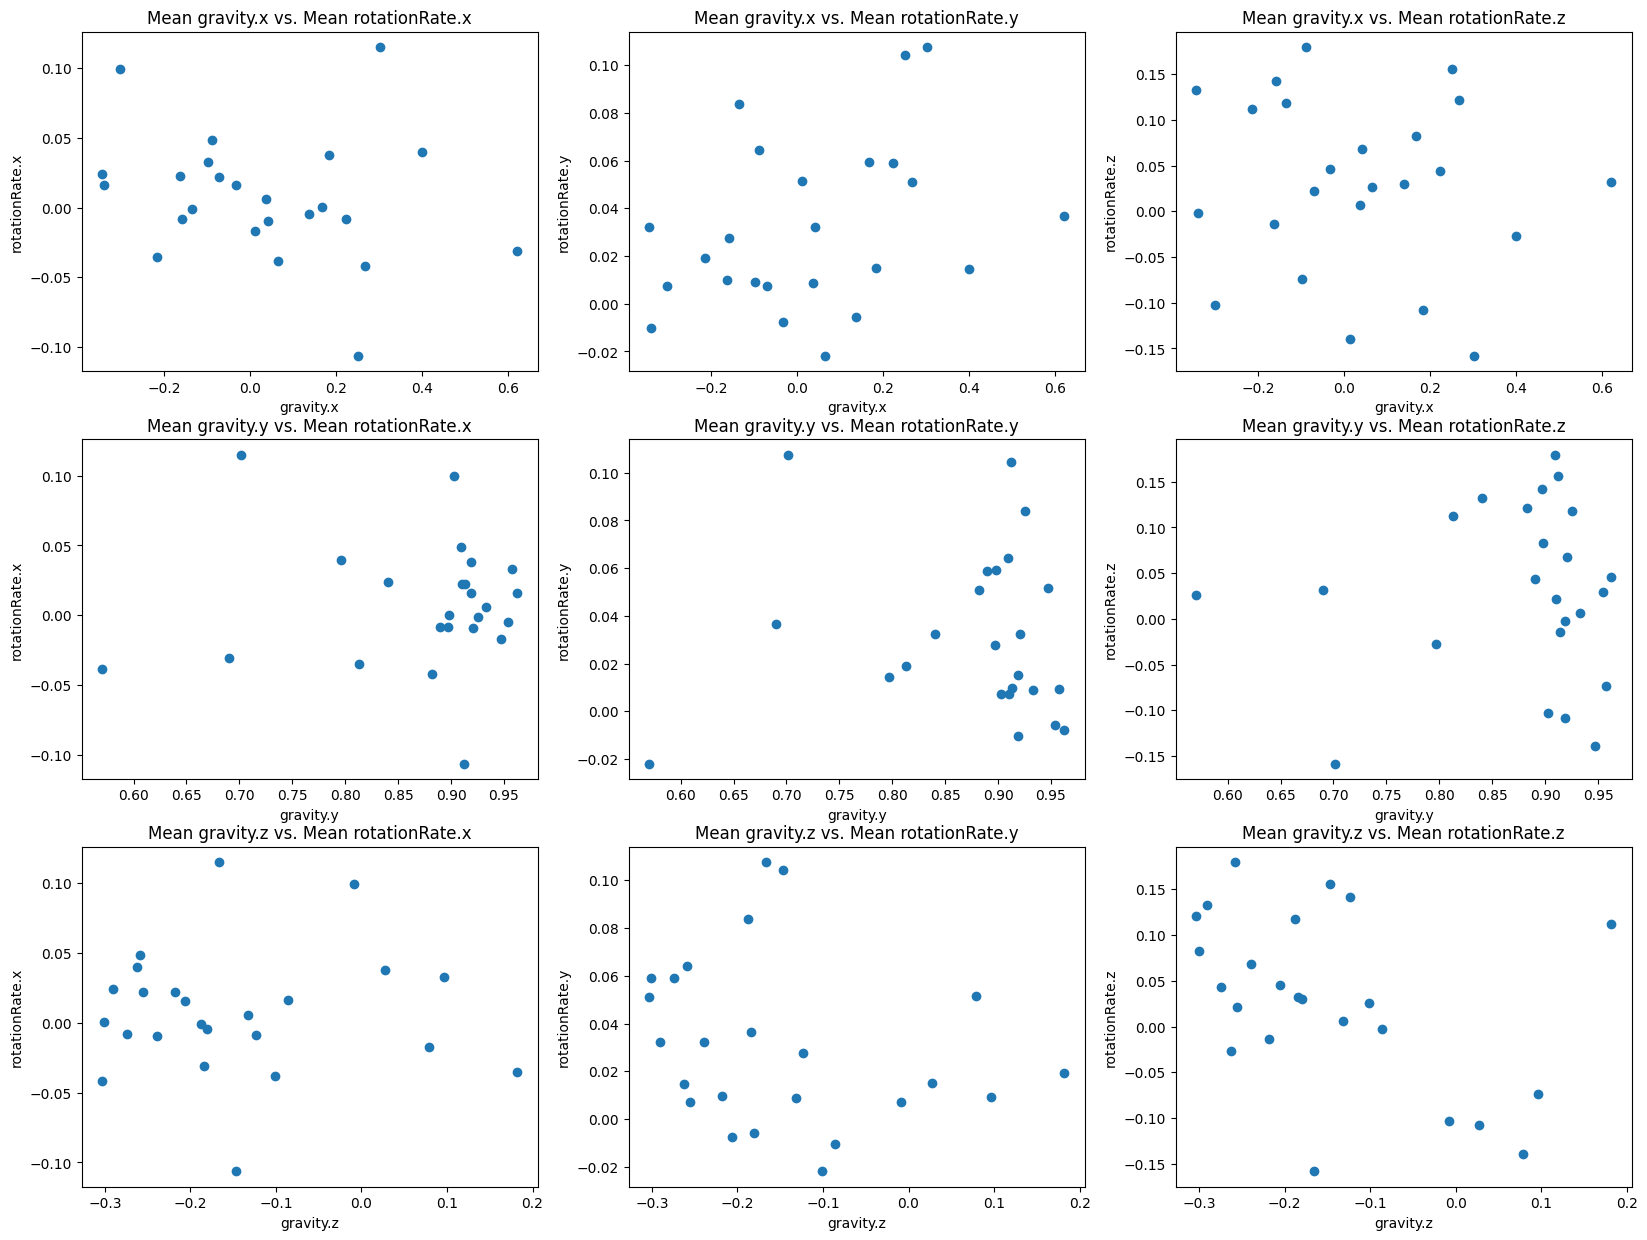

In [23]:
# for example, say we're are focusing on walking
# rotationRate.[x/y/z] vs gravity.[x/y/z]
walking_df = motion_avgs['wlk']

grav_xyz = ['gravity.x', 'gravity.y', 'gravity.z']
rotation_xyz = ['rotationRate.x', 'rotationRate.y', 'rotationRate.z']

figure, axis = plt.subplots(3, 3, figsize=(20, 15))

# scatterplot matrix for gravity.[x/y/z] vs rotationRate.[x/y/z]
for i in range(0, len(grav_xyz)):
    for j in range(0, len(rotation_xyz)):
        axis[i, j].scatter(x=walking_df[grav_xyz[i]], y=walking_df[rotation_xyz[j]])
        axis[i, j].set_title("Mean " + grav_xyz[i] + " vs. Mean " + rotation_xyz[j])
        axis[i,j].set_xlabel(grav_xyz[i])
        axis[i,j].set_ylabel(rotation_xyz[j])
plt.show()

Based on visual inspection: 
Generally speaking, there seems to be weak correlation between gravity dimensional data and rotationRate data for the walking observations
for gravity and rotationRate of different letters

What about the correlation between average gravity and rotation rate of the same dimension?
From inspection, there is a weak negative correlation.

In [24]:
pearson_coefs = [sci.pearsonr(walking_df['gravity.x'], walking_df['rotationRate.x']),
                 sci.pearsonr(walking_df['gravity.y'], walking_df['rotationRate.y']),
                 sci.pearsonr(walking_df['gravity.z'], walking_df['rotationRate.z'])]
pearson_coefs_map = list(map((lambda r_corr_test: (r_corr_test.statistic, r_corr_test.pvalue)), pearson_coefs))

# 0 index -> x
# 1 index -> y
# 2 index -> z
for i in range(len(pearson_coefs_map)):
    print(['x:', 'y:', 'z:'][i] + " r = " + str((pearson_coefs_map[i][0])) + " p-value=" + str(pearson_coefs_map[i][1]))

x: r = -0.22997501260534733 p-value=0.2796653682453301
y: r = -0.014948763126923448 p-value=0.9447286887226123
z: r = -0.4351958584763344 p-value=0.033549546846224625


## MANOVA

In this exploration, we will be looking at the four kinds of active motions (walking, jogging, going upstairs, and going downstairs).
Specifically, we will be testing for whether there is any significable difference between the different kinds of motions and the general rotation velocities that we see.

In [25]:
manova_df = pd.DataFrame(columns = ['Activity', 'rotationRateX', 'rotationRateY', 'rotationRateZ'])

# Fill up the manova data
for activity_prefix in ['wlk', 'ups', 'dws', 'jog']:
  csv_names = []

  # For every folder whose name starts with the prefix
  folder_names = [f for f in os.listdir('A_DeviceMotion_data') if f.startswith(activity_prefix)]
  for folder_name in folder_names:
    # For every csv inside those folders:
    these_names = [f for f in os.listdir('A_DeviceMotion_data/'+folder_name) if f.endswith('.csv')]
    csv_names.extend(these_names)

  # Now, we have all the csv's
  for csv_name in csv_names:
    # Read the csv
    full_csv_name = 'A_DeviceMotion_data/'+folder_name+'/'+csv_name
    df_full = pd.read_csv(full_csv_name)

    df_full.dropna(inplace=True) # just in case
    
    # Fill up the new dataframe
    avg_x = df_full['rotationRate.x'].abs().mean()
    avg_y = df_full['rotationRate.y'].abs().mean()
    avg_z = df_full['rotationRate.z'].abs().mean()

    manova_df.loc[len(manova_df)] = [activity_prefix, avg_x, avg_y, avg_z]

manova_df

,Activity,rotationRateX,rotationRateY,rotationRateZ
0,wlk,1.876488,1.491614,0.551218
1,wlk,1.649619,1.020533,0.670874
2,wlk,0.863968,0.686256,0.770936
3,wlk,1.182331,1.198608,1.363506
4,wlk,1.186141,1.200116,0.584594
...,...,...,...,...
259,jog,2.784325,2.728351,1.214659
260,jog,1.058893,0.704312,0.598713
261,jog,1.373832,1.739999,1.685387
262,jog,1.778247,1.629658,1.812501


Now we can perform a MANOVA test, does the activities differ significantly based on the rotation rates?

MANOVA evaluates whether there are statistically significant differences in the means of multiple dependent variables for different levels of independent variables. This is particularly useful when the dependent variables are interrelated.

In [26]:
manova_calculation = MANOVA.from_formula('Activity ~ rotationRateX + rotationRateY + rotationRateZ', data=manova_df)
print(manova_calculation.mv_test())

                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept                Value         Num DF  Den DF          F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda                0.0000 4.0000 257.0000 289356276058554304.0000 0.0000
         Pillai's trace                1.0000 4.0000 257.0000 289356276058554304.0000 0.0000
 Hotelling-Lawley trace 4503599627370495.0000 4.0000 257.0000 289356276058554304.0000 0.0000
    Roy's greatest root 4503599627370495.0000 4.0000 257.0000 289356276058554304.0000 0.0000
--------------------------------------------------------------------------------------------
                                                                                            
-----------

## Primary and Machine Learning Analysis

In Summary Statistics and Subject Analysis, it can be observed that there is a class imbalance (several movement types have higher observation counts, see Frequencies of Motion Types). This is where the random forest classifier shines. When the classifier generated several decision trees, it addressed the problem of other models learning to classify the majority data label as opposed to properly identifying the correct data label. Although random forest performs the best based on this logic, it is interesting to see how other models fare in comparison quantitatively.

Correlation Analysis of Motion Sensor Metrics: The absence of multicollinearity as demonstrated by correlation analysis between different features indicates that it is safe to conclude that the metrics are indeed solely impactful on the final prediction and not other features. We can apply machine learning after performing normalization on the user rotation and acceleration.

Through MANOVA, we learned that different movement classes have statistically significant difference in their associated rotation rates, which hints to the idea that rotation rate is an important predictive feature. 

Therefore, it is most appropriate to use a classifier trained on rotation and acceleration data to predict the current activity of an individual.

**Imports**

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [28]:
#Note that we aren't able to use the train_test_split as we aren't treating each row as it's own separate data
#Also, there are 9 long trials and 6 short trials which means we have a good split with 60% for training and 40% for testing
def train_test_split(df, target_label):
       train_df = df[df['trial_type'] == 'long']
       test_df = df[df['trial_type'] == 'short']

       X_train = train_df.drop(columns=['subject_code',
              'motion_type', 'trial_type', 'file_path'], axis=1)
       y_train = train_df[target_label]

       X_test = test_df.drop(columns=['subject_code',
              'motion_type', 'trial_type', 'file_path'], axis=1)
       y_test = test_df[target_label]

       return X_train, X_test, y_train, y_test

# Used tofit multiple models to the training data
@ignore_warnings(category=ConvergenceWarning)
def fit_model(models, X, y):
    for _, model in models.items():
        model.fit(X, y)

# Used to print accuracy of multiple models on the test data
def accuracy(models, X, y):
    for model_name, model in models.items():
        prediction = model.predict(X)
        print(model_name, ": ", accuracy_score(y, prediction))

# Used to evaluate model accuracy by motion type
def accuracy_by_motion_type(models, X, y):
    motion_types = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']
    results = {model_name: {motion: 0 for motion in motion_types} for model_name in models.keys()}
    
    for model_name, model in models.items():
        predictions = model.predict(X)
        for motion in motion_types:
            # Get the indices of the current motion type
            motion_indices = (y == motion)
            # Count the correct predictions for the current motion type
            correct_predictions = sum(predictions[motion_indices] == motion)
            # Count the total predictions for the current motion type
            total_predictions = motion_indices.sum()
            results[model_name][motion] = correct_predictions / total_predictions if total_predictions > 0 else 0
    
    return results

### Motion Type Detection

First, we will test a variety of models to see what is a good match.

In [29]:
models = {"KNN": KNeighborsClassifier(n_neighbors=3), "DecisionTree": DecisionTreeClassifier(), "Logistic Regression": LogisticRegression(max_iter=150), "Random Forest": RandomForestClassifier(n_estimators=10)}

In [30]:
#Only consider norms for each metric as it would not only take too long to train off of so many columns but doesn't affect accuracy too much
df['rotationRate_norm'] = np.sqrt(
    df['rotationRate.x']**2 + df['rotationRate.y']**2 + df['rotationRate.z']**2
)
df['userAcceleration_norm'] = np.sqrt(
    df['userAcceleration.x']**2 + df['userAcceleration.y']**2 + df['userAcceleration.z']**2
)
#Drop useless columns
df.drop(columns=['attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z'], axis=1, inplace=True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df, 'motion_type')
X_train

,reading_number,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,rotationRate_norm,userAcceleration_norm
197394,0,-0.177723,0.579787,0.054386,0.214328,0.492025,-0.302982,0.608848,0.616298
197395,1,-0.067688,-1.144894,-0.040912,0.328053,0.593585,-0.637472,1.147623,0.930770
197396,2,1.302963,-0.370412,0.095856,0.505807,0.587823,-0.593140,1.357979,0.976315
197397,3,2.188627,-0.371017,0.544288,0.460187,0.772399,-0.496127,2.285605,1.026895
197398,4,3.500057,-1.530151,0.767509,0.105454,0.640555,-0.316882,3.896259,0.722389
...,...,...,...,...,...,...,...,...,...
1412860,2327,0.833153,-0.095074,0.246557,-0.031468,0.477521,-0.195183,0.874056,0.516830
1412861,2328,0.382486,0.304818,0.267466,0.035374,0.267260,-0.173922,0.557447,0.320824
1412862,2329,0.001522,0.571208,0.313602,-0.088900,0.245480,-0.018898,0.651634,0.261765
1412863,2330,-0.339789,0.333859,0.291225,-0.136894,0.136482,0.119108,0.558328,0.227055


In [32]:
fit_model(models, X_train, y_train)
accuracy(models, X_test, y_test)

KNN :  0.5768166580672804
DecisionTree :  0.6481463042251652
Logistic Regression :  0.5491175822750054
Random Forest :  0.7106472471403269


As we can see, the random forest has the best performance with logistic being the worst. This may be because the random forest helps to mollify some of the spikes or other outliers within the data that a decision tree might overfit on but especially with a logistic regression, since we know that some of the predictors are much stronger from our previous explorations, the logistic coefficient algorithm becomes unreliable in presence of that.

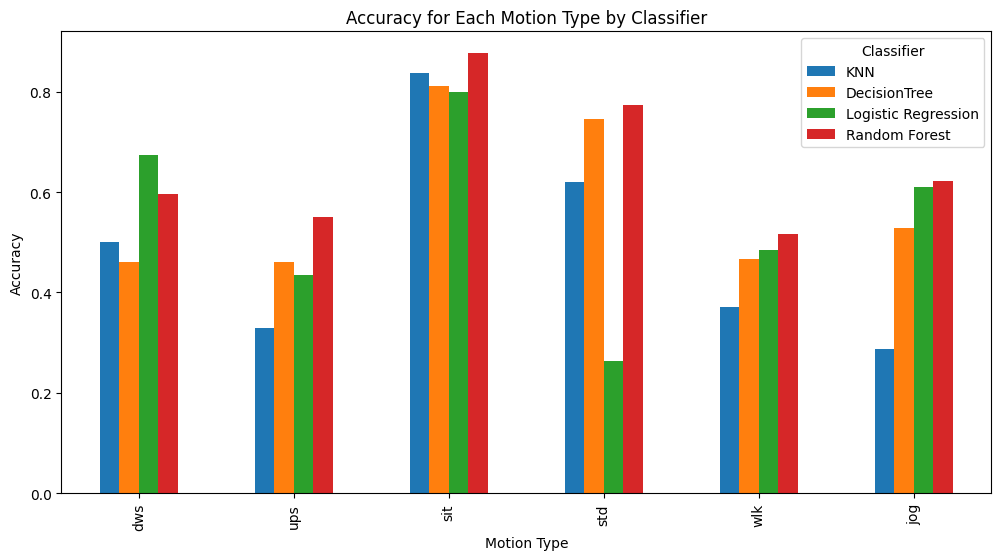

In [33]:
# Calculate accuracy by motion type
accuracy_results = accuracy_by_motion_type(models, X_test, y_test)

# Convert the results to a DataFrame for easier plotting
accuracy_df = pd.DataFrame(accuracy_results)

# Plot the accuracy for each motion type
accuracy_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Motion Type')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Motion Type by Classifier')
plt.legend(title='Classifier')
plt.show()

**Feature Engineering for Time Series Analysis** <br>
Notice that we currently aren't taking into consideration the metrics that are close to each other. This information could be fairly useful. It is what is known as seasonality which is a pattern in the time series data that can only be seen over time. We will be applying two techniques that will hopefully improve our accuracy.

**Lag Features** <br>
Lag features use past values of a time series to predict future values. They help capture patterns over time. The purpose for this is to improve the model's ability to learn from past data, making predictions more accurate.

In [34]:
def create_lag_features(n, cols):
    lag_df = df.copy()
    
    # Create lagged columns
    lagged_columns = []
    for j in cols:
        for i in range(n):
            lagged_columns.append(lag_df[j].shift(i + 1).rename(f"{j}_lag{i + 1}"))

    lag_df = pd.concat([lag_df] + lagged_columns, axis=1)

    #Dropping overlaps
    lag_df = lag_df.drop(index=range(n))
    
    return lag_df

In [35]:
lag_models = {"Random Forest": RandomForestClassifier(n_estimators=10), "Logistic Regression": LogisticRegression(max_iter=250)}

In [36]:
lag_df = create_lag_features(50, ['rotationRate_norm', 'userAcceleration_norm'])
lag_df

,reading_number,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject_code,motion_type,trial_type,...,userAcceleration_norm_lag41,userAcceleration_norm_lag42,userAcceleration_norm_lag43,userAcceleration_norm_lag44,userAcceleration_norm_lag45,userAcceleration_norm_lag46,userAcceleration_norm_lag47,userAcceleration_norm_lag48,userAcceleration_norm_lag49,userAcceleration_norm_lag50
50,50,-1.313179,-3.001811,0.144933,0.224450,-0.258263,0.174714,12,dws,short,...,0.469938,0.615977,1.022539,1.298763,1.204225,1.086566,0.800635,0.631762,0.621363,0.557491
51,51,-1.480255,-2.035555,0.543111,0.205689,-0.174981,0.121802,12,dws,short,...,0.845679,0.469938,0.615977,1.022539,1.298763,1.204225,1.086566,0.800635,0.631762,0.621363
52,52,-1.393782,-1.596769,0.495083,0.059930,-0.201092,0.016130,12,dws,short,...,1.113773,0.845679,0.469938,0.615977,1.022539,1.298763,1.204225,1.086566,0.800635,0.631762
53,53,-1.379712,-1.160785,0.411301,-0.355445,-0.396850,0.000710,12,dws,short,...,1.022346,1.113773,0.845679,0.469938,0.615977,1.022539,1.298763,1.204225,1.086566,0.800635
54,54,-1.136358,-1.196768,-0.124268,-0.572910,-0.200621,-0.045380,12,dws,short,...,0.469679,1.022346,1.113773,0.845679,0.469938,0.615977,1.022539,1.298763,1.204225,1.086566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412860,2327,0.833153,-0.095074,0.246557,-0.031468,0.477521,-0.195183,23,dws,long,...,0.139551,0.378863,0.280269,0.385686,0.724179,0.922205,1.229051,0.538361,0.491884,0.556767
1412861,2328,0.382486,0.304818,0.267466,0.035374,0.267260,-0.173922,23,dws,long,...,0.261274,0.139551,0.378863,0.280269,0.385686,0.724179,0.922205,1.229051,0.538361,0.491884
1412862,2329,0.001522,0.571208,0.313602,-0.088900,0.245480,-0.018898,23,dws,long,...,0.569702,0.261274,0.139551,0.378863,0.280269,0.385686,0.724179,0.922205,1.229051,0.538361
1412863,2330,-0.339789,0.333859,0.291225,-0.136894,0.136482,0.119108,23,dws,long,...,0.731397,0.569702,0.261274,0.139551,0.378863,0.280269,0.385686,0.724179,0.922205,1.229051


In [37]:
lag_X_train, lag_X_test, lag_y_train, lag_y_test = train_test_split(lag_df, 'motion_type')

In [38]:
fit_model(lag_models, lag_X_train, lag_y_train)

In [39]:
accuracy(lag_models, lag_X_test, lag_y_test)

Random Forest :  0.8626817837516485
Logistic Regression :  0.605992111513147


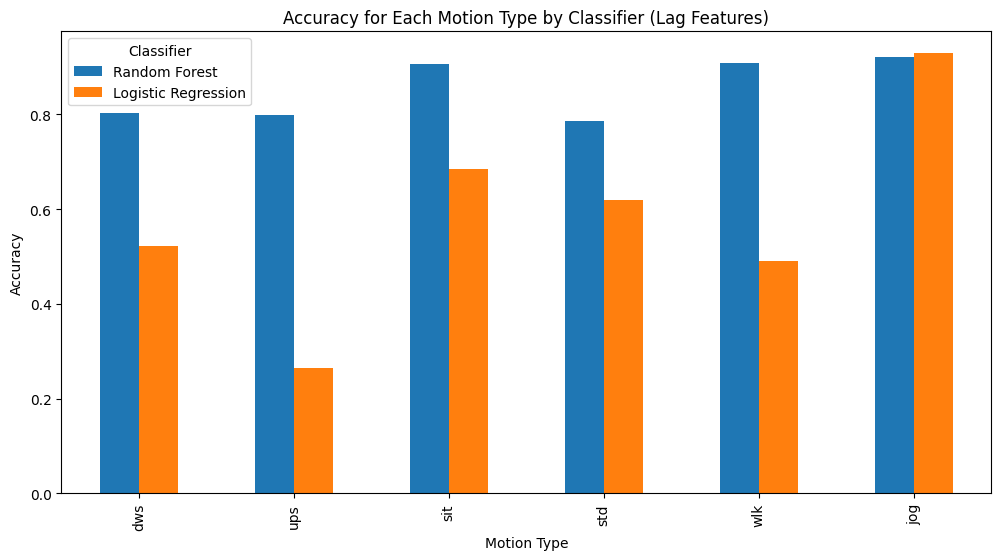

In [40]:
# Again, calculate accuracy by motion type
accuracy_results = accuracy_by_motion_type(lag_models, lag_X_test, lag_y_test)

# Convert the results to a DataFrame for easier plotting
accuracy_df = pd.DataFrame(accuracy_results)

# Plot the accuracy for each motion type
accuracy_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Motion Type')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Motion Type by Classifier (Lag Features)')
plt.legend(title='Classifier')
plt.show()

**Rolling Window Statistics**
Rolling window statistics calculate metrics (like mean or standard deviation) over a moving window of fixed size in the time series data. The purpose is to try to help smooth out short-term fluctuations and highlight longer-term trends or patterns in the data.



In [41]:
def create_rolling_statistics(cols, window_sizes, stats):
    rolling_df = df.copy()
    
    for col in cols:
        for window in window_sizes:
            for stat in stats:
                stat_name = stat.__name__
                rolling_df[f"{col}_rolling_{stat_name}_{window}"] = rolling_df[col].rolling(window=window).apply(stat)
    
    # Dropping all rows where the rolling window does not have enough data
    rolling_df = rolling_df.dropna().reset_index(drop=True)
    
    return rolling_df

In [42]:
rolling_models = {"Random Forest": RandomForestClassifier(n_estimators=10), "Logistic Regression": LogisticRegression(max_iter=250)}

We can look at the average from the past 5, 10, 20, 25 readings.

In [43]:
rolling_df = create_rolling_statistics(['rotationRate_norm', 'userAcceleration_norm'], [5, 10, 20, 25], [pd.Series.mean, pd.Series.std])
rolling_df

,reading_number,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject_code,motion_type,trial_type,...,rotationRate_norm_rolling_mean_25,rotationRate_norm_rolling_std_25,userAcceleration_norm_rolling_mean_5,userAcceleration_norm_rolling_std_5,userAcceleration_norm_rolling_mean_10,userAcceleration_norm_rolling_std_10,userAcceleration_norm_rolling_mean_20,userAcceleration_norm_rolling_std_20,userAcceleration_norm_rolling_mean_25,userAcceleration_norm_rolling_std_25
0,24,0.285804,-2.940555,0.755296,-0.122540,-0.324802,0.383889,12,dws,short,...,2.644888,1.095378,0.587016,0.063253,0.541692,0.094945,0.689926,0.290307,0.699853,0.273406
1,25,-0.058580,-2.350632,0.581219,-0.151399,-0.318381,0.255166,12,dws,short,...,2.666371,1.085073,0.539278,0.070905,0.546520,0.087103,0.651475,0.268730,0.694962,0.277128
2,26,-0.234225,-2.035833,0.331761,-0.131354,-0.273685,0.178691,12,dws,short,...,2.690850,1.063506,0.483946,0.089081,0.527197,0.106607,0.604150,0.229169,0.684198,0.285214
3,27,-0.303334,-1.999415,0.075927,-0.062679,-0.214346,0.155896,12,dws,short,...,2.727239,1.022060,0.425411,0.114899,0.502568,0.133787,0.566640,0.218216,0.669821,0.296790
4,28,-0.269969,-2.099005,-0.089287,0.032135,-0.084830,0.062920,12,dws,short,...,2.787475,0.932688,0.337557,0.156532,0.474104,0.181115,0.541361,0.240361,0.642212,0.315622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412836,2327,0.833153,-0.095074,0.246557,-0.031468,0.477521,-0.195183,23,dws,long,...,1.441161,0.641202,0.694900,0.200064,0.686115,0.192549,0.518176,0.227192,0.553123,0.270174
1412837,2328,0.382486,0.304818,0.267466,0.035374,0.267260,-0.173922,23,dws,long,...,1.399732,0.664025,0.567558,0.193635,0.663781,0.221604,0.525309,0.218008,0.516868,0.234395
1412838,2329,0.001522,0.571208,0.313602,-0.088900,0.245480,-0.018898,23,dws,long,...,1.353253,0.674433,0.451607,0.159067,0.619626,0.254413,0.525989,0.217118,0.486567,0.214891
1412839,2330,-0.339789,0.333859,0.291225,-0.136894,0.136482,0.119108,23,dws,long,...,1.346788,0.681494,0.396120,0.182649,0.582083,0.283286,0.518654,0.224871,0.477758,0.220995


In [44]:
rolling_X_train, rolling_X_test, rolling_y_train, rolling_y_test = train_test_split(rolling_df, 'motion_type')

In [45]:
fit_model(rolling_models, rolling_X_train, rolling_y_train)

In [46]:
accuracy(lag_models, lag_X_test, lag_y_test)

Random Forest :  0.8626817837516485
Logistic Regression :  0.605992111513147


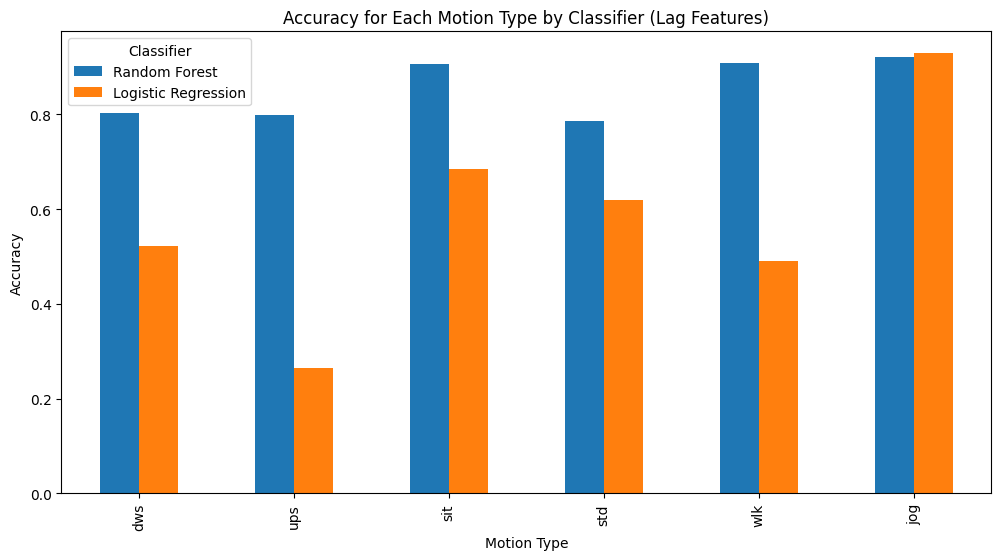

In [47]:
# Again, calculate accuracy by motion type
accuracy_results = accuracy_by_motion_type(lag_models, lag_X_test, lag_y_test)

# Convert the results to a DataFrame for easier plotting
accuracy_df = pd.DataFrame(accuracy_results)

# Plot the accuracy for each motion type
accuracy_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Motion Type')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Motion Type by Classifier (Lag Features)')
plt.legend(title='Classifier')
plt.show()

### "Fingerprinting" Subjects
We can perform the same thing with "subject code" as the target label.

Random Forest :  0.8637108480274256
Logistic Regression :  0.605992111513147


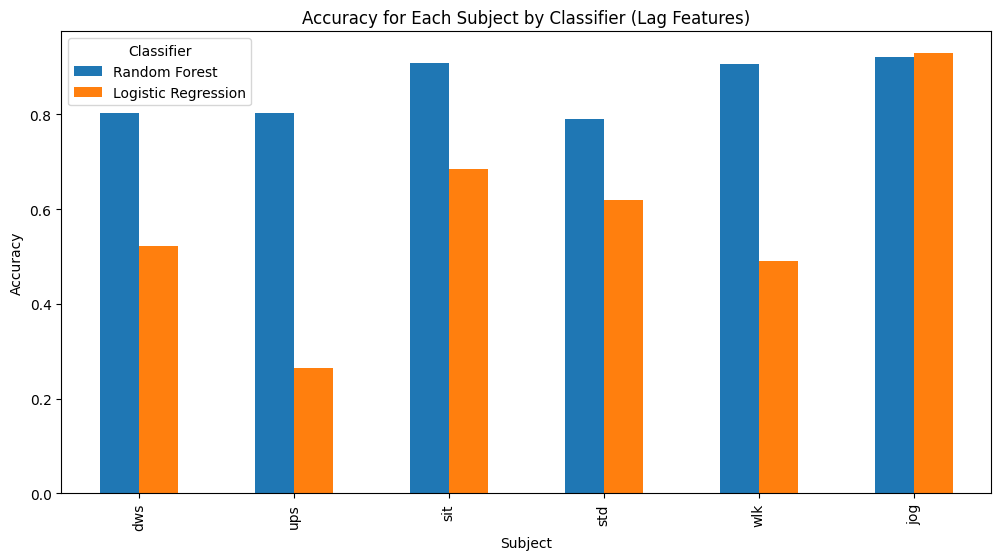

In [48]:
subject_lag__models = {"Random Forest": RandomForestClassifier(n_estimators=10), "Logistic Regression": LogisticRegression(max_iter=250)}
subject_lag_X_train, subject_lag_X_test, subject_lag_y_train, subject_lag_y_test = train_test_split(lag_df, 'subject_code')
fit_model(lag_models, lag_X_train, lag_y_train)
accuracy(lag_models, lag_X_test, lag_y_test)

#Accuracy Plot
accuracy_results = accuracy_by_motion_type(lag_models, lag_X_test, lag_y_test)

accuracy_df = pd.DataFrame(accuracy_results)

accuracy_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Subject by Classifier (Lag Features)')
plt.legend(title='Classifier')
plt.show()

Look at that, performance was quite well for the Random Forest Classifier

## Insights and Conclusion
It is most appropriate to use random tree classifier trained on rotation and acceleration data to predict the current activity of an individual. This kind of classifier could be improved by applying additional cleaning to the rotation and acceleration data as well as making more use of the time series nature of the data. A future direction may be to find a deep representation extractable from movement activities over time in order to do more precise fingerprinting, to this end more exploratory data analysis would be needed.

Based on the results of model training and data analysis, we conclude that several metrics do have strong predictive power. User rotation and user acceleration both seem to be independent of each other, so the issue of multicollinearity is not a problem. With these features, the class of movement can be predicted with high accuracy.

For health application tracking, user rotation and user acceleration sensors can be utilized to accurately alert the user about which bin to put their exercise session in.

## Useful Resources for More Time Series Analysis

[A Comprhensive Guide to Time Series Analysis](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/) <br>
[Practical Guide for Feature Engineering of Time Series Data](https://dotdata.com/blog/practical-guide-for-feature-engineering-of-time-series-data/)